This is a simple notebook to show the effect of Ridge and Lasso regularization.

It accompanies Chapter 5 of the book (3 of 5).

Author: Viviana Acquaviva

In [30]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

font = {'size'   : 16}
matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
matplotlib.rcParams.update({'figure.autolayout': False})
matplotlib.rcParams['figure.dpi'] = 300

In [31]:
from sklearn import linear_model

In [32]:
from sklearn.linear_model import Ridge, Lasso

In [33]:
from sklearn.preprocessing import PolynomialFeatures

In [34]:
from sklearn.model_selection import cross_validate, KFold

Let's generate data for a linear model in 3 dimensions.

In [35]:
np.random.seed(16) #set seed for reproducibility purposes

x1 = np.arange(100) 

x2 = np.linspace(0,1,100)

x3 = np.logspace(2,3,num=100) 

ypb = 3*x1 + 0.5*x2 + 15*x3 + 3 + 5*(np.random.poisson(3*x1 + 0.5*x2 + 15*x3,100)-(3*x1 + 0.5*x2 + 15*x3)) 
                                                    #generate some data with scatter following Poisson distribution 
                                                    #with exp value = y from linear model, centered around 0

In [36]:
xb = np.vstack((x1,x2,x3)).T

In [37]:
xb.shape

(100, 3)

### Add correlated features (polynomial transformation)

In [38]:
poly = PolynomialFeatures(2, include_bias=False)

In [39]:
new_xb = poly.fit_transform(xb)

In [40]:
new_xb.shape

(100, 9)

### Let's start with Ridge regression, and tune alpha using cross-validation.

(note what happens if repeating a few times without fixing the random seed).

In [41]:
MSE = []

for alpha in np.logspace(-6,6,13):

    model_reg = Ridge(alpha = alpha, normalize = True) #normalization helps

    scores = cross_validate(model_reg, new_xb, ypb, cv = KFold(n_splits=10, shuffle=True, random_state = 1), scoring = 'neg_mean_squared_error')

    print(alpha, np.round(-np.mean(scores['test_score'])))
    
    MSE.append(-np.mean(scores['test_score']))

print('Best alpha:', np.logspace(-6,6,13)[np.argmin(MSE)])

1e-06 159544.0
1e-05 159577.0
0.0001 159199.0
0.001 161629.0
0.01 159954.0
0.1 159140.0
1.0 325243.0
10.0 4666343.0
100.0 13563179.0
1000.0 15739401.0
10000.0 15985734.0
100000.0 16010689.0
1000000.0 16013187.0
Best alpha: 0.1


### There is also a built-in instrument for this!

In [42]:
from sklearn.linear_model import RidgeCV

In [43]:
regm = RidgeCV(alphas=np.logspace(-6,6,13), normalize=True, \
               cv = KFold(n_splits=10, shuffle=True, random_state=1),\
             scoring = 'neg_mean_squared_error')

regm.fit(new_xb,ypb) #this calls the "fit" method, which means that I obtain the coefficients.

RidgeCV(alphas=array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06]),
        cv=KFold(n_splits=10, random_state=1, shuffle=True), normalize=True,
        scoring='neg_mean_squared_error')

### We can compare the coefficients of the linear model for different amounts of regularization.

#### Let's pick alpha = 1000.

In [44]:
model = Ridge(alpha = 1000., normalize = True)

In [45]:
model.fit(new_xb,ypb)

coef_alpha_1000 =  np.hstack([model.coef_, model.intercept_]) #Note the intercept is the last number


print(coef_alpha_1000)

[1.29764875e-01 1.28467226e+01 1.54128052e-02 1.31732946e-03
 1.30415617e-01 1.42251352e-04 1.29111460e+01 1.40828839e-02
 1.48143307e-05 5.99685176e+03]


#### Now let's see for alpha = 1.0.

Will the coefficients be larger or smaller?

In [46]:
model = Ridge(alpha = 1., normalize = True)

In [47]:
model.fit(new_xb,ypb)

coef_alpha_1 =  np.hstack([model.coef_, model.intercept_]) #Note the intercept is the last number

print(coef_alpha_1)

[1.29503196e+01 1.28208164e+03 1.59973226e+00 1.36205885e-01
 1.34843826e+01 1.49543095e-02 1.33495388e+03 1.48047664e+00
 1.57290083e-03 1.65472805e+03]


#### Trick to get coefficients for tiny alpha (no regularization); I could have also used LinearRegressor.

In [48]:
model = Ridge(alpha = 1e-7, normalize = True)

model.fit(new_xb,ypb)

coef_no_reg =  np.hstack([model.coef_, model.intercept_])

print(coef_no_reg)

[ 3.32874617e+02  3.29545871e+04 -3.92599642e+02  1.48665142e+00
  1.47178494e+02  1.58279095e+00  1.45706711e+04  1.56696303e+02
 -5.65916016e-02  4.12053615e+04]


### We can compare the coefficients for the three cases.

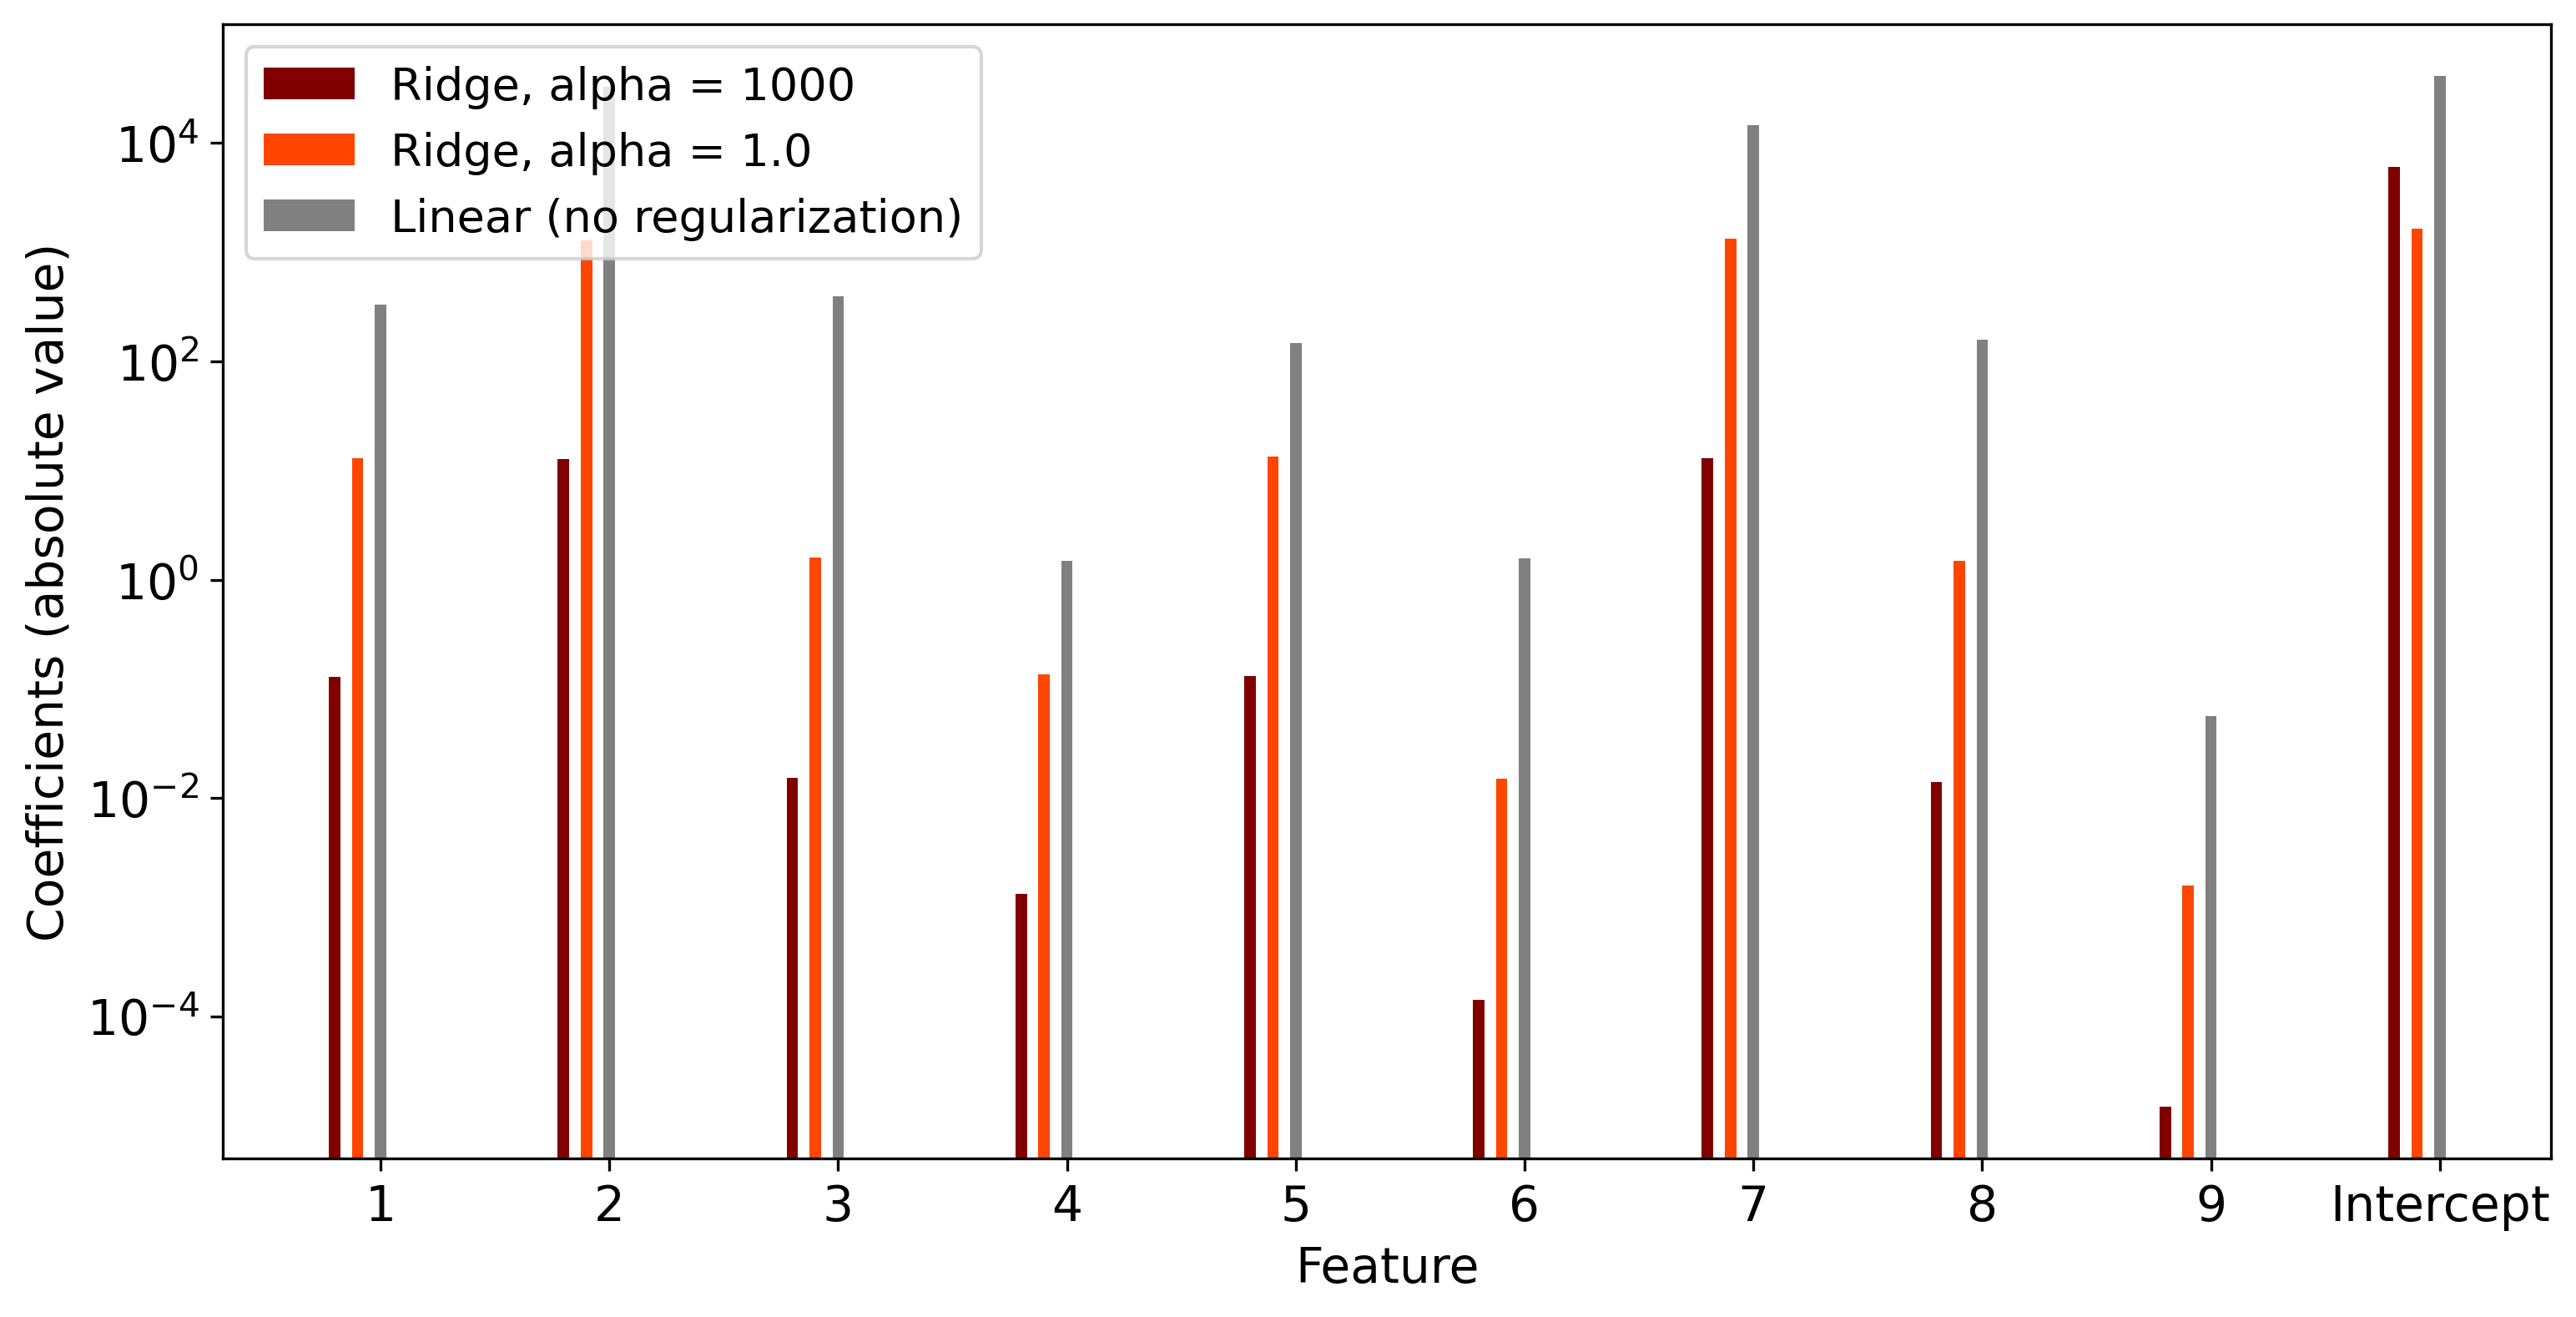

In [49]:
plt.figure(figsize = (12,6))
plt.bar(np.arange(10)-0.2, np.abs(coef_alpha_1000), color = 'maroon',width=0.05, label = 'Ridge, alpha = 1000')
plt.bar(np.arange(10)-0.1, np.abs(coef_alpha_1), color = 'orangered',width=0.05, label = 'Ridge, alpha = 1.0')
plt.bar(range(10), np.abs(coef_no_reg), color = 'grey',width=0.05, label = 'Linear (no regularization)')
plt.yscale('log')

plt.xticks(np.arange(10), ['1','2', '3','4','5','6','7','8','9', 'Intercept'])  # Set text labels.

plt.xlabel('Feature',fontsize=14)

plt.ylabel('Coefficients (absolute value)',fontsize=14)

plt.legend(fontsize=13);

### Let's take a look at LASSO.

In [50]:
from sklearn.linear_model import Lasso, LassoCV 

In [51]:
#Note: LassoCV re-orders alphas in DESCENDING ORDER! Scores will be messed up unless you use model.alphas_ object

model = LassoCV(alphas = np.logspace(-2,2,5), cv = KFold(n_splits=10, shuffle=True, random_state=1), \
              max_iter = 1000000, tol = 1e-6, normalize=True)

model.fit(new_xb,ypb)

print('Alphas', model.alphas_)

print('Best alpha:', model.alpha_)

for i, alpha in enumerate(model.alphas_):
    print('Score for alpha', alpha, np.mean(model.mse_path_[i,:])) #for each alpha (row), 10 cv estimates of MSE

Alphas [1.e+02 1.e+01 1.e+00 1.e-01 1.e-02]
Best alpha: 1.0
Score for alpha 100.0 1096308.7860023652
Score for alpha 10.0 168707.39392115848
Score for alpha 1.0 158809.7476180755
Score for alpha 0.1 160543.79864529864
Score for alpha 0.01 160549.23022346786


#### <font color = 'red'> Note: early reproducibility issues were solved by setting tolerance to a small value (thanks to Joel Zinn!). </font>

### We can of course also use the "regular" Lasso and do CV ourselves.

Let's look at the coefficients for alpha = 1000 and alpha = 1. Lasso regularization tends to induce sparse coefficients, so we can check that that's true!

In [52]:
L1000 = Lasso(alpha = 1000, max_iter = 1000000, tol = 0.005, normalize=True)

L1000.fit(new_xb, ypb)

coef_L1000 =  np.hstack([L1000.coef_, L1000.intercept_])

In [53]:
coef_L1000

array([   0.       ,    0.       ,    0.       ,    0.       ,
          0.       ,    0.       ,    0.       ,    0.       ,
          0.       , 6039.4703773])

In [54]:
L1 = Lasso(alpha = 1.0, max_iter = 1000000, tol = 0.005, normalize=True)

L1.fit(new_xb, ypb)

coef_L1 = np.hstack([L1.coef_, L1.intercept_])

In [55]:
coef_L1

array([2.83619997e+01, 8.42192697e-12, 7.99924234e+00, 1.89893109e-02,
       0.00000000e+00, 2.12275841e-02, 1.81554156e+00, 0.00000000e+00,
       1.93916019e-03, 4.49575486e+02])

In [56]:
coef_no_reg

array([ 3.32874617e+02,  3.29545871e+04, -3.92599642e+02,  1.48665142e+00,
        1.47178494e+02,  1.58279095e+00,  1.45706711e+04,  1.56696303e+02,
       -5.65916016e-02,  4.12053615e+04])

### Finally, we can plot all the coefficients together.

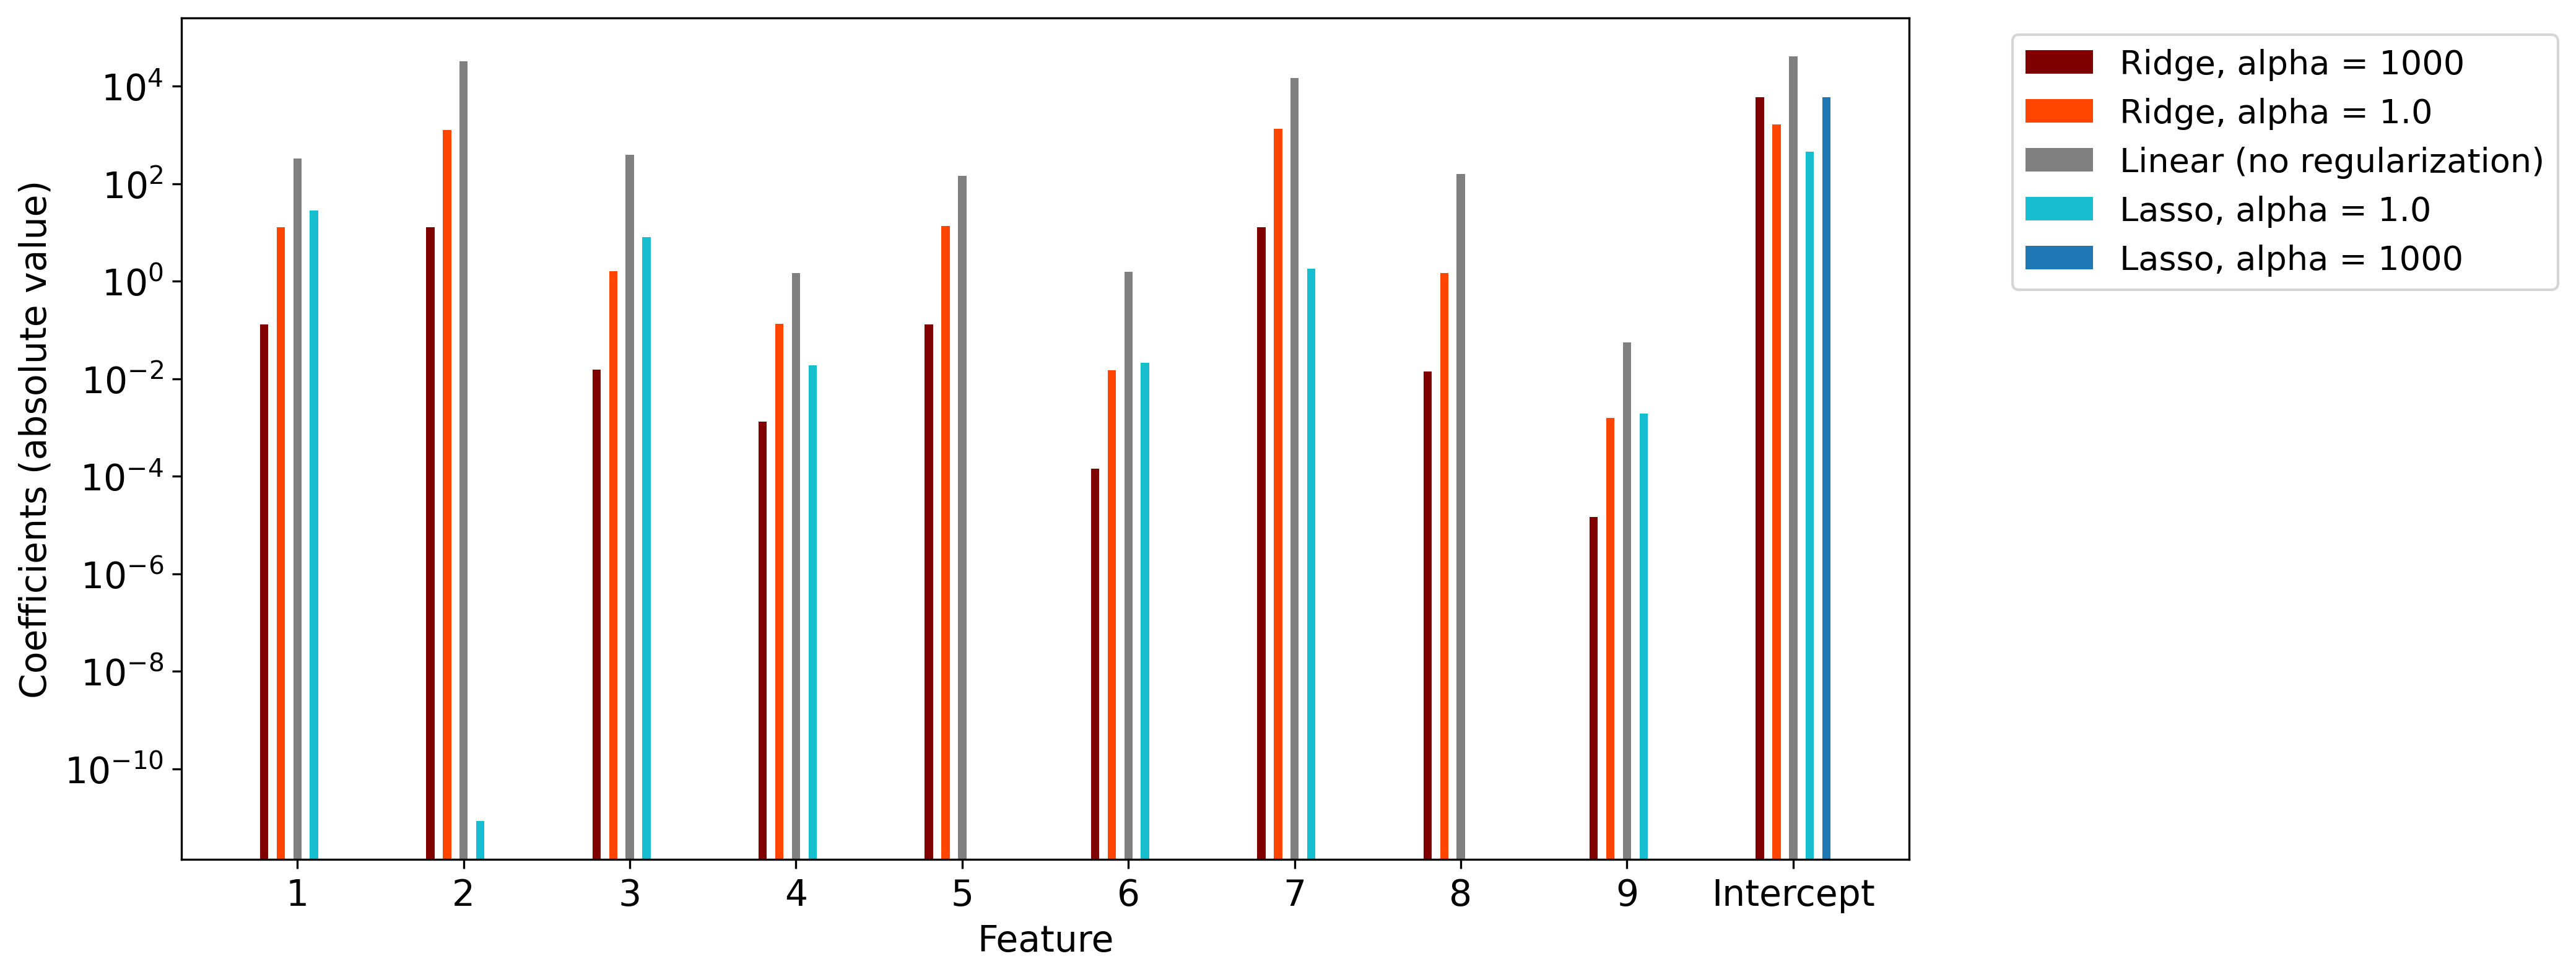

In [57]:
plt.figure(figsize = (12,6))
plt.bar(np.arange(10)-0.2, np.abs(coef_alpha_1000), color = 'maroon',width=0.05, label = 'Ridge, alpha = 1000')
plt.bar(np.arange(10)-0.1, np.abs(coef_alpha_1), color = 'orangered',width=0.05, label = 'Ridge, alpha = 1.0')
plt.bar(range(10), np.abs(coef_no_reg), color = 'grey',width=0.05, label = 'Linear (no regularization)')
plt.bar(np.arange(10)+0.1, np.abs(coef_L1), color = 'tab:cyan',width=0.05, label = 'Lasso, alpha = 1.0')
plt.bar(np.arange(10)+0.2, np.abs(coef_L1000), color = 'tab:blue', width=0.05, label = 'Lasso, alpha = 1000')

plt.yscale('log')

plt.xticks(np.arange(10), ['1','2', '3','4','5','6','7','8','9', 'Intercept'])  # Set text labels.

plt.xlabel('Feature',fontsize=14)

plt.ylabel('Coefficients (absolute value)',fontsize=14)

plt.legend(fontsize=13, bbox_to_anchor=(1.05, 1));
